In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import community as louvain
import networkx as nx
from networkx.algorithms import community
import itertools
import seaborn as sns
import json

# Network analysis | ***G1: Interaction network***
This notebook contains following sections:
1. **Building the network representation** of G1
2. **Explorative data analysis** of G1
3. **Community detection** in G1
  * Louvain
  * Infomap
  * Baseline homophily
3. **Visualizations of G1 and its community structures**

In [7]:
with open('edgelist.json', 'r') as edge_f:
    edge_data = json.load(edge_f)
with open('nodelist.json', 'r') as node_f:
    node_data = json.load(node_f)

### Simple network for testing community detection

In [8]:
G = nx.DiGraph()
G.add_edges_from(edge_data)

In [11]:
len(G.nodes)

116409

In [12]:
len(G.edges)

174910

## Full interaction network

In [549]:
## Transform into the complete interaction network (summing up all attributes)

In [550]:
sumf = lambda x: (x[0],x[1],{'interactions': (x[2]['replies'] + x[2]['retweets'] + x[2]['orig_mentions'])})
edges_i = list(map(sumf, G.edges(data=True)))

In [551]:
G_i = nx.DiGraph()
G_i.add_edges_from(edges_i)
G_i = G_i.to_undirected()

#### Pick n users with most interactions and create a sub-graph based on these users

In [596]:
n = 100000
i_node_subset = sorted(G_i.degree(weight='interactions'), key=lambda x: x[1], reverse=True)[:n]

In [597]:
i_node_subset = [i[0] for i in i_node_subset]  

In [598]:
G_i = nx.subgraph(G_i, i_node_subset)

In [599]:
len(G_i)

100000

# Community detection on interaction network

## 1. ***Louvain*** - Modularity based

In [601]:
comms_l_complete = louvain.best_partition(G_i, weight='interactions')

In [602]:
from collections import Counter

#### Select $n_c = 5$ largest communities

In [603]:
n_c = 5
comms_l_sel = sorted(Counter(comms_l_complete.values()).items(), key=lambda x: x[1], reverse=True)[:n_c]

In [604]:
comms_l = []
for c_k in comms_l_sel:
    comms_l.append([x for x,y in comms_l_complete.items() if y == c_k[0]])

#### Visualizing 

In [605]:
G_i = nx.DiGraph()
G_i.add_edges_from(edges_i)
G_i = G_i.to_undirected()

In [606]:
subg_nodes = set()
for com in comms_l:
    for e in com:
        subg_nodes.add(e)

In [607]:
len(subg_nodes)

25362

In [608]:
G_subi = nx.subgraph(G_i, subg_nodes)

In [609]:
len(G_subi)

25362

#### Select color palette

In [610]:
colors = sns.color_palette("husl", n_c)

#### Tuned mapping function for mapping edge weights $ \rightarrow $ edge widths 

In [611]:
Sigm = lambda x: (x/50 + .1) * 1 / (1 + np.exp(-x))

In [612]:
intrs = list(filter(lambda x: x > 1, [v for (i,k,v) in G_subi.edges(data='interactions')]))
e_widths = list(map(Sigm, intrs))

#### Calculate weight proportions of the $n_c$ communities wrt to complete data

In [614]:
# Proportion of users in the chosen set of largest n_c communities
sum([comms_l_sel[i][1] for i in range(n_c)]) / len(comms_l_complete)

0.25362

#### Calculate edge proportions of the $n_c$ communities wrt to complete data

In [615]:
# Proportion of edges in the chosen set of largest n_c communities
sum([w for (_,_,w) in G_subi.edges(data='interactions')]) / sum([w for (_,_,w) in G_i.edges(data='interactions')])

0.26039041035870947

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

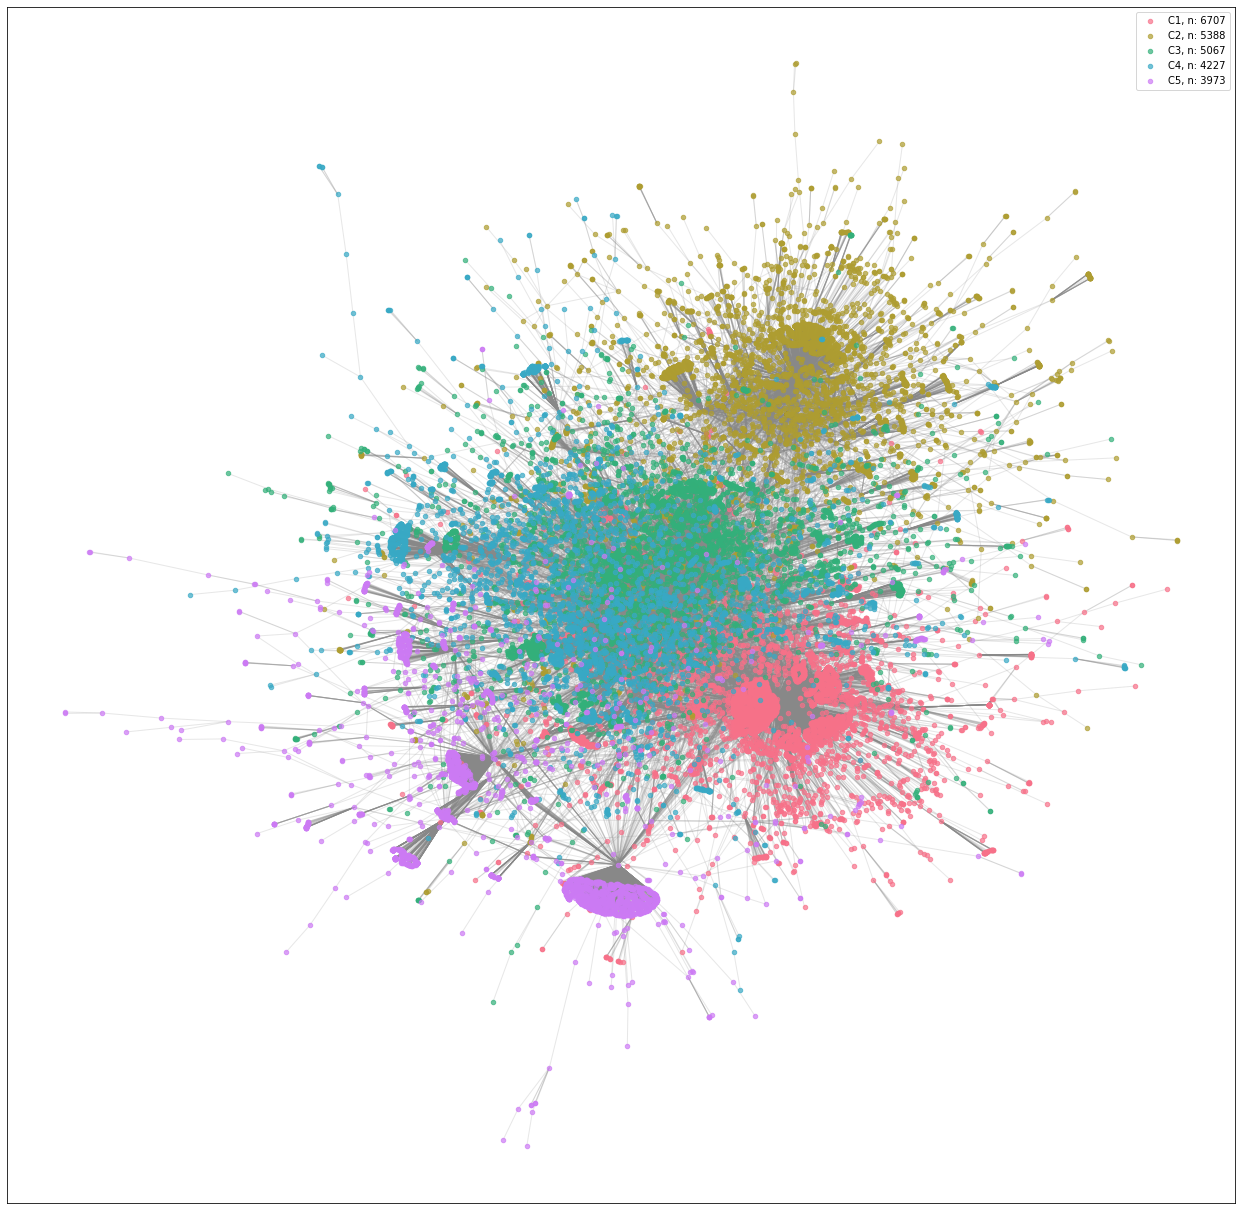

In [616]:
f, ax = plt.subplots(figsize=(22,22))
layout = nx.spring_layout(G_subi, iterations=50)

nx.draw_networkx_edges(G_subi, ax=ax, pos=layout, widths=e_widths, edgelist=G_subi.edges, alpha=0.2,  edge_color ="#888888")
for i,col,com in zip(range(n_c),colors,comms_l):
    nx.draw_networkx_nodes(G_subi, pos=layout, nodelist=com, node_size=20, alpha=0.55, node_color=col, label='C{}, n: {}'.format(i+1, len(com)))
    
plt.legend(loc='best')